---
title: Getting Started
---

This notebook uses [Python 3.8](https://docs.python.org/3/) and the open source package [SimPEG](https://simpeg.xyz). [SimPEG](https://simpeg.xyz) can be installed using the python package manager PyPi and running:

```sh
conda install SimPEG --channel conda-forge
```

This tutorial consists of 3 parts, here, we introduce the problem, in [divergence.ipynb](divergence.ipynb) we build the discrete divergence operator and in [weak-formulation.ipynb](weak-formulation.ipynb), we discretize and solve the DC equations using weak formulation.

**Notebooks**
- [Mesh](mesh.ipynb)
- [Divergence](divergence.ipynb)
- [Weak forulation](weak-formulation.ipynb)
- [All together now](all-together-now.ipynb)

# DC Resistivity

```{figure} ../images/dc-setup.png
Setup of a direct current (DC) resistivity survey.
```

DC resistivity surveys obtain information about subsurface electrical conductivity, $\sigma$. This physical property is often diagnostic in mineral exploration, geotechnical, environmental and hydrogeologic problems, where the target of interest has a significant electrical conductivity contrast from the background. In a DC resistivity survey, steady state currents are set up in the subsurface by injecting current through a positive electrode and completing the circuit with a return electrode.

## Deriving the DC equations


```{figure} ../images/dc-eqns.png
Derivation of the DC resistivity equations.
```

Conservation of charge (which can be derived by taking the divergence of Ampere’s law at steady state) connects the divergence of the current density everywhere in space to the source term which consists of two point sources, one positive and one negative. The flow of current sets up electric fields according to Ohm’s law, which relates current density to electric fields through the electrical conductivity. From Faraday’s law for steady state fields, we can describe the electric field in terms of a scalar potential, $\phi$, which we sample at potential electrodes to obtain data in the form of potential differences.

## The finish line
*Where are we going??* 

Here, we are going to do a run through of how to setup and solve the DC resistivity equations for a 2D problem using [SimPEG](http://simpeg.xyz). This is meant to give you a once-over of the whole picture. We will break down the steps to get here in the series of notebooks that follow...

In [10]:
# Import numpy, python's n-dimensional array package,
# the mesh class with differential operators from SimPEG
# matplotlib, the basic python plotting package
import numpy as np
import discretize
from SimPEG import utils
import matplotlib.pyplot as plt
%matplotlib inline

### Mesh

Where we solve things! See [mesh.ipynb](mesh.ipynb) a discussion of how we construct a mesh and the associated properties we need. 

The mesh has 8000 cells.


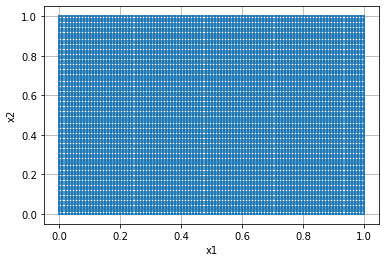

In [11]:
# Define a unit-cell mesh
mesh = discretize.TensorMesh([100, 80])  # setup a mesh on which to solve
print("The mesh has {nC} cells.".format(nC=mesh.nC))

mesh.plot_grid()
plt.axis('tight');

### Physical Property Model

Define an electrical conductivity ($\sigma$) model, on the cell-centers of the mesh. 

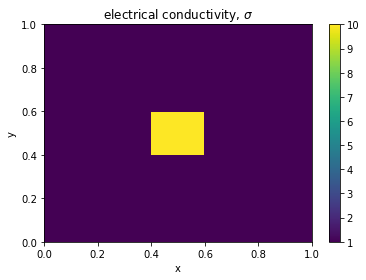

In [12]:
# model parameters
sigma_background = 1.  # Conductivity of the background, S/m
sigma_block = 10.  # Conductivity of the block, S/m

# add a block to our model
x_block = np.r_[0.4, 0.6]
y_block = np.r_[0.4, 0.6]

# assign them on the mesh
sigma = sigma_background * np.ones(mesh.nC)  # create a physical property model 

block_indices = ((mesh.gridCC[:,0] >= x_block[0]) & # left boundary
                 (mesh.gridCC[:,0] <= x_block[1]) & # right boundary
                 (mesh.gridCC[:,1] >= y_block[0]) & # bottom boundary
                 (mesh.gridCC[:,1] <= y_block[1]))  # top boundary

# add the block to the physical property model
sigma[block_indices] = sigma_block

# plot it!
plt.colorbar(mesh.plot_image(sigma)[0])
plt.title('electrical conductivity, $\sigma$');

### Define a source

Define location of the positive and negative electrodes

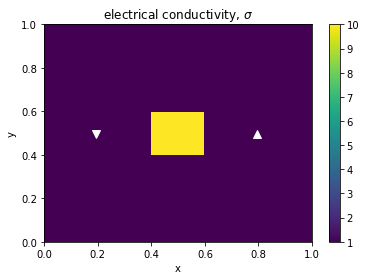

In [13]:
# Define a source
a_loc, b_loc = np.r_[0.2, 0.5], np.r_[0.8, 0.5]
source_locs = [a_loc, b_loc]

# locate it on the mesh
source_loc_inds = mesh.closest_points_index(source_locs)
a_loc_mesh = mesh.gridCC[source_loc_inds[0],:]
b_loc_mesh = mesh.gridCC[source_loc_inds[1],:]

# plot it
plt.colorbar(mesh.plot_image(sigma)[0])
plt.plot(a_loc_mesh[0], a_loc_mesh[1],'wv', markersize=8) # a-electrode
plt.plot(b_loc_mesh[0], b_loc_mesh[1],'w^', markersize=8) # b-electrode
plt.title('electrical conductivity, $\sigma$');

### Assemble and solve the DC system of equations

How we construct the divergence operator is discussed in [divergence.ipynb](divergence.ipynb), and the inner product matrix in [weakformulation.ipynb](weakformulation.ipynb). The final system is assembled and discussed in [play.ipynb](play.ipynb) (with widgets!).

In [14]:
# Assemble and solve the DC resistivity problem
Div = mesh.face_divergence
Sigma = mesh.get_face_inner_product(sigma, invert_model=True, invert_matrix=True)
Vol = utils.sdiag(mesh.cell_volumes)

# assemble the system matrix
A = Vol * Div * Sigma * Div.T * Vol

# right hand side
q = np.zeros(mesh.nC)
q[source_loc_inds] = np.r_[+1, -1]

In [15]:
from SimPEG import Solver # import the default solver (LU)

In [16]:
# solve the DC resistivity problem
Ainv = Solver(A)  # create a matrix that behaves like A inverse
phi = Ainv * q

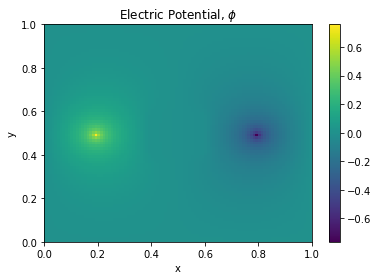

In [17]:
# look at the results!
plt.colorbar(mesh.plot_image(phi)[0])
plt.title('Electric Potential, $\phi$');

## What just happened!?

In the notebooks that follow, we will:

- define where variables live on the mesh ([mesh.ipynb](mesh.ipynb))
- define the discrete divergence ([divergence.ipynb](divergence.ipynb))
- use the weak formulation to define a solveable system of equations ([weak-formulation.ipynb](weak-formulation.ipynb))
- solve and play with the DC resistivity equations ([all-together-now.ipynb](all-together-now.ipynb))